In [1]:
import os
import pandas as pd
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
from torch.quantization import quantize_dynamic
from transformers import Trainer, TrainingArguments, RobertaForSequenceClassification, RobertaTokenizer
from datasets import load_dataset

from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load the model from the checkpoint
checkpoint_path = "./results/roberta/checkpoint-9900/"

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Load the model from the checkpoint directory
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:

# Load data
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")
train_file = Path(data_path, 'train_data_only_text_and_labels.csv')
eval_file = Path(data_path, 'eval_data_only_text_and_labels.csv')
test_file = Path(data_path, 'test_data_only_text_and_labels.csv')

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)
test_df = pd.read_csv(test_file)


In [4]:
train_df

,text_combined,label
0,mr benson eko bbennisadinetcomuy benson eko ch...,1
1,millicent boston helgagermanflintcochraneorg r...,1
2,jason ling vytekdemisehotmailcom _nextpart_001...,0
3,vladimir antalik ohrbzoznamsk would like purch...,0
4,lennart regebro hyiffbigmailcom wed mar 26 200...,0
...,...,...
52785,justin shore listuserneopittstateedu 116 pm 04...,0
52786,charles philip chan optgpesympaticoca aaron ku...,0
52787,isador kee catimen84swannejp dear d59ebf6a0f14...,1
52788,global risk management operations weekly opera...,0


In [5]:
!pip install --upgrade torch torchvision

In [17]:
import torch
from transformers import Trainer, TrainingArguments, RobertaForSequenceClassification, RobertaTokenizer
from torch.quantization import quantize_dynamic
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
import os
import copy
from transformers import Trainer, TrainingArguments, RobertaForSequenceClassification, RobertaTokenizer
from datasets import load_dataset
import torch.nn.utils.prune as prune

# Load the model from the checkpoint
checkpoint_path = "./results/roberta/checkpoint-9900/"
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Load the model from the checkpoint directory
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)

### Prune the model

In [11]:
# Define a helper function to apply global pruning
def apply_global_pruning(model, amount=0.3):
    # Loop through each module in the model and prune if it is a Linear or Conv layer
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv1d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')  # Remove the reparameterization to make it permanent

# Apply global pruning to the model (adjust the amount based on your needs)
apply_global_pruning(model, amount=0.3)

### Save pruned model

In [14]:
torch.save(model, "./results/roberta/fine_tune/prune/pruned_model.pth")



### Load pruned model

In [3]:
model_architecture = "roberta-large"  # Use the same architecture that was originally quantized
pruned_model_save_path = "./results/roberta/fine_tune/prune/pruned_model.pth"
pruned_model = torch.load("./results/roberta/fine_tune/prune/pruned_model.pth")

In [18]:
def count_non_zero_weights(model):
    non_zero_count = 0
    for param in model.parameters():
        non_zero_count += torch.sum(param != 0).item()
    return non_zero_count

# Count non-zero weights in the original model
original_non_zero_weights = count_non_zero_weights(model)

# Count non-zero weights in the pruned model
pruned_non_zero_weights = count_non_zero_weights(pruned_model)

# Print results
print(f"Original model non-zero weights: {original_non_zero_weights}")
print(f"Pruned model non-zero weights: {pruned_non_zero_weights}")

# Calculate and print the reduction ratio
reduction_ratio = (original_non_zero_weights - pruned_non_zero_weights) / original_non_zero_weights
print(f"Reduction in non-zero weights: {reduction_ratio:.2%}")

Original model non-zero weights: 355361792
Pruned model non-zero weights: 264449629
Reduction in non-zero weights: 25.58%


In [3]:
# Evaluate the pruned model using metric_fn function
# Load the pruned model
model = torch.load("./results/roberta/fine_tune/prune/pruned_model.pth")
# Ensure the model is on the correct device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [11]:
def metric_fn(eval_pred):

    
    # Extract predictions and labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Convert logits to predicted class
    
    # Compute basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    
    # Compute AUC
    if len(np.unique(labels)) > 1:  # Check if there is more than one class in labels
        auc = roc_auc_score(labels, logits[:, 1])  # Use probability of the positive class
    else:
        auc = float('nan')  # If only one class is present, AUC is not defined

    # Compute running time

    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
    }

In [32]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer
from datasets import Dataset
import pandas as pd
import time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

# Example test_df DataFrame


# Convert test_df to Dataset if it's a DataFrame
test_dataset = Dataset.from_pandas(test_df)

# Initialize tokenizer (make sure to use the correct tokenizer for your model)
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

# Define a function to tokenize the inputs
def tokenize_function(examples):
    return tokenizer(examples['text_combined'], padding='max_length', truncation=True)

# Apply the tokenizer to the dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Define evaluation arguments
eval_args = TrainingArguments(
    output_dir='./results/roberta/fine_tune/prune',
    per_device_eval_batch_size=50,
    logging_dir='./results/roberta/fine_tune/prune',
    evaluation_strategy="epoch"  # Ensure evaluation is done at the end of each epoch
)

# Define the Trainer with the quantized model
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=metric_fn  # Uncomment if you have a metric function defined
)

# Evaluate the model on the tokenized test dataset
evaluation_results = trainer.evaluate()

# Print evaluation results
print(evaluation_results)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16498 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 0.03362153097987175, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.9904230815856467, 'eval_precision': 0.9864818024263432, 'eval_recall': 0.9952208882154098, 'eval_f1': 0.990832076128583, 'eval_auc': 0.9993942411525625, 'eval_running_time': 0.019478559494018555, 'eval_runtime': 159.9472, 'eval_samples_per_second': 103.147, 'eval_steps_per_second': 2.063}


In [12]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 355361794


In [13]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
get_model_size(model)

1355.5976638793945

In [9]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()
X_test = test["text_combined"].tolist()
y_test = test["label"]


In [10]:
test.shape

(16498, 2)

Confusion Matrix:
[[7802  117]
 [  41 8538]]
Accuracy: 0.9904230815856467
Precision: 0.9864818024263432
Recall: 0.9952208882154098
F1-Score: 0.990832076128583
AUC: 0.9993843128513828
eval_time: 9871.871952056885


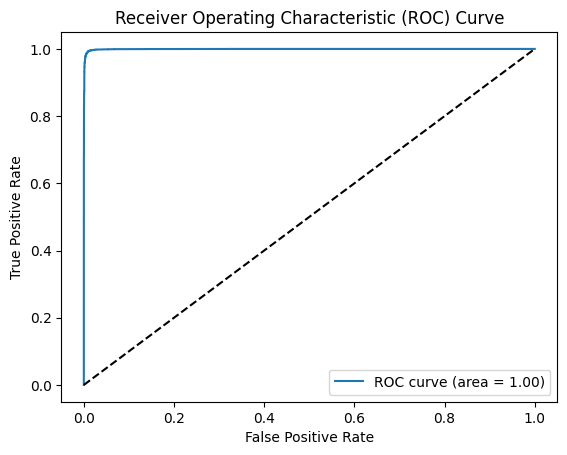

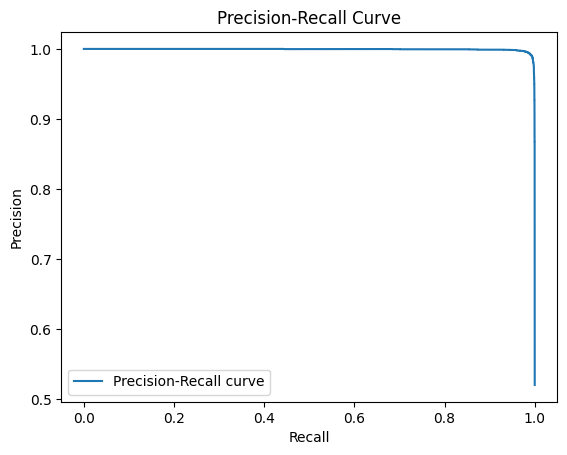

In [11]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import time
# Function to evaluate the model on the test set in batches
def evaluate_in_batches(model, tokenizer, X_test, y_test, batch_size):
    device = torch.device("cpu")  # Change to "cuda" if GPU is available and required
    model.to(device)
    model.eval()

    # Split the test set into batches
    num_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

    all_predictions = []
    all_probs = []
    all_true_labels = []
    start_time = time.time()
    with torch.no_grad():
        for i in range(num_batches):
            # Get the batch data
            batch_texts = X_test[i * batch_size: (i + 1) * batch_size]
            batch_labels = y_test[i * batch_size: (i + 1) * batch_size]

            # Tokenize the batch
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Get logits from the model
            outputs = model(**inputs)
            logits = outputs.logits.cpu()
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu()

            # Get the predicted labels
            predictions = torch.argmax(probs, dim=1).cpu()

            # Store the results
            all_predictions.append(predictions.numpy())
            all_probs.append(probs[:, 1].numpy())
            all_true_labels.append(batch_labels.to_numpy())

    # Concatenate all batch results
    y_pred = np.concatenate(all_predictions)
    y_scores = np.concatenate(all_probs)
    y_true = np.concatenate(all_true_labels)
    total_time = time.time() - start_time
    # Calculate evaluation metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    evaluation_results = {
        "Confusion_Matrix": cm,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Evaluation_Time": total_time
    }
    # Print results
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)
    print("eval_time:", total_time)
    # ROC Curve
    with open(f'./results/roberta/fine_tune/prune/pruned_model_eval_results_cpu.txt', 'w') as f:
        f.write(f"{evaluation_results}\n\n")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    return cm
# Example usage
batch_size = 500  # Set the desired batch size
cm = evaluate_in_batches(model, tokenizer, X_test, y_test, batch_size)

 

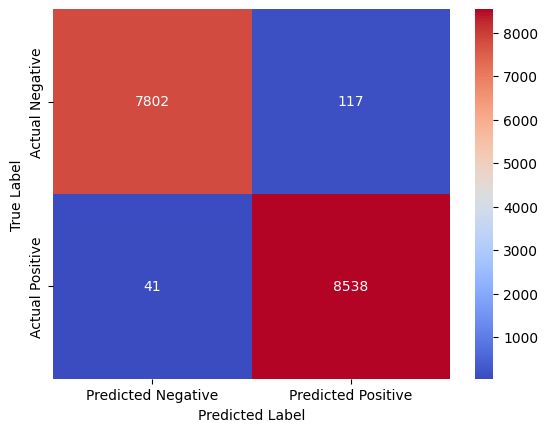

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()
